# Regression Baseline Model:

Uses "MSH3_dataset_IFP_pIC50_May312022" from Fang-Yu 05/13/2022
"Docking the tested molecules into new MSH3 crystal structure" to Predict Active Binders Energies Using Regression

Using compound interaction fingerprints (CDK, and ECFP6) from Rob Stanten
 June 22 2022: Copyright,  Andrew Kiruluta, Pfizer
 

In [56]:
import pandas as pd
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, MaxAbsScaler
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn import metrics
import torch

# Seed
seed = 123
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
random.seed(seed)

import warnings
warnings.filterwarnings('ignore')

In [57]:
df = pd.read_csv("data/MSH3_dataset_IFP_pIC50_May312022.csv")
df.head(5)

,Ligand,Hydrophobic,Weak hydrogen bond,Van der Waals,Hydrogen bond,Face-to-face pi-stacking,Displaced face-to-face pi-stacking,Face-to-slope pi-stacking,Unfavorable nucleophile-nucleophile,Ionic,...,Chalcogen-pi,Parallel multipolar,Halogen bond,Edge-to-slope pi-stacking,Edge-to-face pi-stacking,Halogen-pi,Anion-electrophile,pIC50 (uM),SMILES,set
0,PF-06453226,4.0,9.0,16,6.0,3.0,2.0,1.0,2.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.746707,[H]OC1([H])C([H])(n2nc([H])c(N([H])c3nc(Oc4c([...,train
1,PF-07916056,6.0,10.0,20,5.0,3.0,2.0,0.0,2.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.497486,[H]c1nn(C2([H])C([H])([H])C([H])([H])[N+]([H])...,train
2,PF-07915990,5.0,12.0,18,5.0,3.0,2.0,0.0,2.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.273178,[H]c1nn(C2([H])C([H])([H])C([H])([H])[N+]([H])...,train
3,PF-06453966,6.0,11.0,17,5.0,3.0,2.0,0.0,2.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.839533,[H]C([H])=C([H])C(=O)N([H])c1c([H])c(F)c([H])c...,train
4,PF-07916053,6.0,10.0,20,5.0,3.0,2.0,1.0,4.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.119863,[H]c1nn(C2([H])C([H])([H])C([H])([H])[N+]([H])...,train


In [58]:
#df = pd.read_csv("data/MSH3_dataset_IFP_pIC50_May312022.csv")
df = pd.read_csv("data/interaction_fingerprints_Rob.csv")
df = df[["PCAT_CMPD_ID","cdk_path_fp","ECFP6_fp","IC50"]]
df.head(5)

,PCAT_CMPD_ID,cdk_path_fp,ECFP6_fp,IC50
0,PF-05067550,"0,1,11,12,14,15,17,22,29,30,33,41,43,48,51,60,...","30,65,101,114,215,228,382,429,462,470,485,623,...",8.459147
1,PF-05773757,"12,16,17,48,59,62,66,70,75,84,86,91,95,101,106...","101,148,216,463,672,792,898,938,1036,1121,1237...",8.930263
2,PF-00475379,"17,25,26,75,76,78,84,86,88,128,148,171,181,206...","6,101,311,333,381,540,545,808,924,1036,1110,11...",7.402823
3,PF-00475374,"17,26,76,78,84,86,88,128,148,171,181,206,208,2...","101,311,545,593,808,1036,1094,1113,1336,1365,1...",7.722347
4,PF-06979777,"7,10,11,12,13,15,17,23,25,27,28,29,33,37,38,40...","10,90,113,161,288,303,369,493,604,611,647,652,...",3.696388


In [59]:
df3 = df.cdk_path_fp.str.split(pat=',',expand=True)
df4 = df.ECFP6_fp.str.split(pat=',',expand=True)
df4.head(5)

,0,1,2,3,4,5,6,7,8,9,...,102,103,104,105,106,107,108,109,110,111
0,30,65,101,114,215,228,382,429,462,470,...,None,None,None,None,None,None,None,None,None,None
1,101,148,216,463,672,792,898,938,1036,1121,...,None,None,None,None,None,None,None,None,None,None
2,6,101,311,333,381,540,545,808,924,1036,...,None,None,None,None,None,None,None,None,None,None
3,101,311,545,593,808,1036,1094,1113,1336,1365,...,None,None,None,None,None,None,None,None,None,None
4,10,90,113,161,288,303,369,493,604,611,...,None,None,None,None,None,None,None,None,None,None


In [62]:
df2 = df4.fillna(value=9999)
df_ECFP6 = df2.loc[:, ~(df2 == 9999).any()]
df_ECFP6["IC50"] = df.IC50
df_ECFP6["PCAT_CMPD_ID"] = df.PCAT_CMPD_ID
df_ECFP6.head(5)

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,IC50,PCAT_CMPD_ID
0,30,65,101,114,215,228,382,429,462,470,...,1327,1378,1576,1592,1609,1778,1968,1996,8.459147,PF-05067550
1,101,148,216,463,672,792,898,938,1036,1121,...,2283,2318,2365,2436,2460,2675,3074,3146,8.930263,PF-05773757
2,6,101,311,333,381,540,545,808,924,1036,...,1576,1609,1733,1865,1924,2017,2043,2104,7.402823,PF-00475379
3,101,311,545,593,808,1036,1094,1113,1336,1365,...,2348,2436,2481,2485,2503,2524,2723,2844,7.722347,PF-00475374
4,10,90,113,161,288,303,369,493,604,611,...,1010,1027,1036,1066,1078,1148,1302,1329,3.696388,PF-06979777


In [63]:
df2 = df3.fillna(value=9999)
df_cdk = df2.loc[:, ~(df2 == 9999).any()]
df_cdk["IC50"] = df.IC50
df_cdk["PCAT_CMPD_ID"] = df.PCAT_CMPD_ID
df_cdk.head(5)

,0,1,2,3,4,5,6,7,8,9,...,29,30,31,32,33,34,35,36,IC50,PCAT_CMPD_ID
0,0,1,11,12,14,15,17,22,29,30,...,108,111,117,119,122,127,128,129,8.459147,PF-05067550
1,12,16,17,48,59,62,66,70,75,84,...,238,243,253,271,275,300,310,311,8.930263,PF-05773757
2,17,25,26,75,76,78,84,86,88,128,...,617,618,621,637,644,669,720,741,7.402823,PF-00475379
3,17,26,76,78,84,86,88,128,148,171,...,760,830,906,912,920,924,929,953,7.722347,PF-00475374
4,7,10,11,12,13,15,17,23,25,27,...,84,86,87,95,98,99,104,108,3.696388,PF-06979777


# Process and Scale Data:

In [64]:
# choose representation to use
df = df_ECFP6
df.set_index('PCAT_CMPD_ID', inplace=True)
df.head(5)

,0,1,2,3,4,5,6,7,8,9,...,19,20,21,22,23,24,25,26,27,IC50
PCAT_CMPD_ID,,,,,,,,,,,,,,,,,,,,,
PF-05067550,30,65,101,114,215,228,382,429,462,470,...,1245,1327,1378,1576,1592,1609,1778,1968,1996,8.459147
PF-05773757,101,148,216,463,672,792,898,938,1036,1121,...,2132,2283,2318,2365,2436,2460,2675,3074,3146,8.930263
PF-00475379,6,101,311,333,381,540,545,808,924,1036,...,1575,1576,1609,1733,1865,1924,2017,2043,2104,7.402823
PF-00475374,101,311,545,593,808,1036,1094,1113,1336,1365,...,2318,2348,2436,2481,2485,2503,2524,2723,2844,7.722347
PF-06979777,10,90,113,161,288,303,369,493,604,611,...,990,1010,1027,1036,1066,1078,1148,1302,1329,3.696388


In [67]:
# Sklearn’s SimpleImputer allows you to replace missing values based on mean/median/most frequent values in the respective columns.
from sklearn.impute import SimpleImputer
imp_mean = SimpleImputer(missing_values=np.nan, strategy='median')  
df2 = pd.DataFrame(imp_mean.fit_transform(df.iloc[:, :-1].values))
df2['IC50'] = list(df['IC50'])

In [68]:
scale = StandardScaler() # works best with pearson correlation 0.5
#scale = RobustScaler()
#scale = MinMaxScaler()
#scale = MaxAbsScaler()

In [69]:
scaled_features = pd.DataFrame(StandardScaler().fit_transform(df2.iloc[:, :-1].values))
scaled_features['IC50'] = list(df['IC50'])
scaled_features.head(5)

,0,1,2,3,4,5,6,7,8,9,...,19,20,21,22,23,24,25,26,27,IC50
0,-0.731173,-0.921305,-1.171444,-1.478018,-1.062218,-1.207062,-0.513629,-0.480754,-0.536499,-0.705417,...,0.239962,0.304358,0.288964,0.619767,0.504499,0.406812,0.658559,0.940711,0.867494,8.459147
1,0.260691,-0.148034,-0.248061,1.058156,1.994973,2.243041,2.306843,2.045474,2.118367,2.149809,...,2.569860,2.739450,2.621863,2.525132,2.492918,2.380886,2.707063,3.407844,3.384387,8.930263
2,-1.066451,-0.585910,0.514734,0.113450,0.048271,0.701506,0.377334,1.400268,1.600345,1.777006,...,1.106778,0.938603,0.862262,0.998908,1.147672,1.137521,1.204370,1.108012,1.103863,7.402823
3,0.260691,1.370557,2.393618,2.002863,2.904772,3.735638,3.378186,2.914019,3.505928,3.219970,...,3.058429,2.905016,2.914716,2.805262,2.608359,2.480634,2.362221,2.624875,2.723429,7.722347
4,-1.010571,-0.688392,-1.075091,-1.136470,-0.573871,-0.748271,-0.584687,-0.163114,0.120280,-0.087004,...,-0.429851,-0.503093,-0.582150,-0.684284,-0.734729,-0.824955,-0.780190,-0.544923,-0.592305,3.696388


In [71]:
from sklearn.model_selection import train_test_split
df_train, df_test, y_train, y_test = train_test_split(scaled_features.iloc[:,:-1], scaled_features['IC50'], test_size=0.33, random_state=42)

# Gradient Boosted Trees (XGBoost)

In [73]:
from numpy import loadtxt
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn import metrics 

# fit model no training data
xgbr = xgb.XGBRegressor(verbosity=1, reg_alpha=0.3, reg_lambda=0.1, max_depth=40, colsample_bytree=0.5, \
    learning_rate=0.1, n_estimators=500)
xgbr.fit(df_train.values, y_train.values)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.5, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.1, max_delta_step=0,
             max_depth=40, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=500, n_jobs=48,
             num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=0.3, reg_lambda=0.1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=1)

# Prediction validation and checking the results

In [80]:
# After training the model, we'll check the model training score.
# OVERFITTING !!!

score = xgbr.score(df_test.values, y_test.values)  
print("test score: ", score)

test score:  0.543396594935998


# Predict on Unseen Data

In [83]:
ypred = xgbr.predict(df_test.values)
mse = metrics.mean_squared_error(y_test.values, ypred)
mae = metrics.mean_absolute_error(y_test.values, ypred)
r2 = metrics.r2_score(y_test.values, ypred)
r = np.corrcoef(y_test.values, ypred) #[1,0]
print("MSE: %.2f" % mse)
print("RMSE: %.2f" % (mse**(1/2.0)))
print("mean absolute error: %.2f" %mae)
#print("pearson correlation: %.2f" %r)

MSE: 45.45
RMSE: 6.74
mean absolute error: 4.25


In [84]:
r

array([[1.        , 0.74976331],
       [0.74976331, 1.        ]])

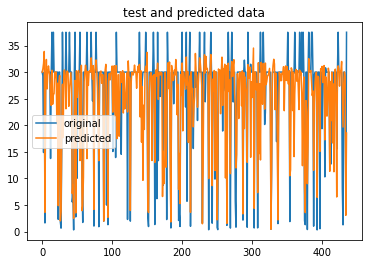

In [76]:
x_ax = range(len(y_test.values))
plt.plot(x_ax, y_test.values, label="original")
plt.plot(x_ax, ypred, label="predicted")
plt.title("test and predicted data")
plt.legend()
plt.show()

# Deep Learning Regression:

In [85]:
# Train Loader
X_train = df_train.values 
y_train = y_train.values
X_train_tensor = torch.from_numpy(X_train)
y_train_tensor = torch.from_numpy(y_train)
train_tensor = torch.tensor(X_train_tensor, dtype=torch.float32)
ytrain_tensor = torch.tensor(y_train_tensor, dtype=torch.float32)

# Passing to DataLoader
train_dataset = torch.utils.data.TensorDataset(train_tensor,ytrain_tensor)
train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=16, shuffle=True)

# Validation Loader
X_valid = df_test.values 
y_valid = y_test.values
X_valid_tensor = torch.from_numpy(X_valid)
y_valid_tensor = torch.from_numpy(y_valid)
valid_tensor = torch.tensor(X_valid_tensor, dtype=torch.float32)
yvalid_tensor = torch.tensor(y_valid_tensor, dtype=torch.float32)

# Passing to DataLoader
valid_dataset = torch.utils.data.TensorDataset(valid_tensor,yvalid_tensor)
valid_loader = torch.utils.data.DataLoader(valid_dataset,batch_size=16, shuffle=True)

In [86]:
# Creating a PyTorch class
# X_train.shape[1] ==> 9 ==> X_train.shape[1]
n_inputs = X_train.shape[1]
class Regression(torch.nn.Module):
	def __init__(self):
		super().__init__()
		
		self.model = torch.nn.Sequential(
			torch.nn.Linear(n_inputs, 1024),
			torch.nn.BatchNorm1d(1024),
			torch.nn.ReLU(),
			torch.nn.Linear(1024, 512),
			torch.nn.BatchNorm1d(512),
			torch.nn.ReLU(),
			torch.nn.Linear(512, 128),
			torch.nn.BatchNorm1d(128),
			torch.nn.ReLU(),
			torch.nn.Linear(128, 64),
			torch.nn.BatchNorm1d(64),
			torch.nn.ReLU(),
			torch.nn.Linear(64, 32),
			torch.nn.BatchNorm1d(32),
			torch.nn.ReLU(),
			torch.nn.Linear(32, 1)
		)
	def forward(self, x):
		out = self.model(x)
		return out

In [87]:
for  x in train_loader:
        x_train, target = x
        print(x_train.size())
        print(target.size())
        break

torch.Size([16, 28])
torch.Size([16])


In [88]:
if torch.cuda.is_available():
	device = torch.cuda.current_device()
x_train = x_train.to(device)
target = target.to(device)

# Train Deep Learning Model:
https://towardsdatascience.com/pytorch-tabular-regression-428e9c9ac93

https://github.com/Bjarten/early-stopping-pytorch/blob/master/MNIST_Early_Stopping_example.ipynb

https://github.com/tuantle/regression-losses-pytorch


In [89]:
# Regression Loss Functions
class LogCoshLoss(torch.nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, y_t, y_prime_t):
        ey_t = y_t - y_prime_t
        return torch.mean(torch.log(torch.cosh(ey_t + 1e-12)))


class XTanhLoss(torch.nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, y_t, y_prime_t):
        ey_t = y_t - y_prime_t
        return torch.mean(ey_t * torch.tanh(ey_t))


class XSigmoidLoss(torch.nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, y_t, y_prime_t):
        ey_t = y_t - y_prime_t
        return torch.mean(2 * ey_t / (1 + torch.exp(-ey_t)) - ey_t)

In [90]:
# import EarlyStopping
from pytorchtools import EarlyStopping


def adjust_learning_rate_poly(optimizer, initial_lr, iteration, max_iter):
    """Sets the learning rate
    # Adapted from PyTorch Imagenet example:
    # https://github.com/pytorch/examples/blob/master/imagenet/main.py
    """
    lr = initial_lr * ( 1 - (iteration / max_iter)) * ( 1 - (iteration / max_iter))
    if ( lr < 1.0e-7 ):
      lr = 1.0e-7

    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

    return lr

# Model Initialization
model = Regression()

# Validation using MSE Loss function
#loss_function = torch.nn.MSELoss()   # worst performance
loss_function = torch.nn.L1Loss()     # best performance - mean absolute error
#loss_function = LogCoshLoss()        # 2nd best performance
#loss_function = XTanhLoss()
#loss_function = XSigmoidLoss()

# Using an Adam Optimizer with lr = 1e-6
lr_rate = 1e-6
optimizer = torch.optim.Adam(model.parameters(),
							lr = lr_rate,
							weight_decay = 1e-8)

epochs = 20000
outputs = []
train_losses = []
valid_losses = []

if torch.cuda.is_available():
	device = torch.cuda.current_device()
	model.to(device)

#pbar_train = tqdm(enumerate(train_loader), total=len(train_loader))
r_corr = []
for epoch in range(0,epochs):
    model.train()
    lr = adjust_learning_rate_poly(optimizer, lr_rate, epoch, epochs)
    loss = 0
    for  x in train_loader:
        x_train, target = x
        x_train = x_train.to(device)
        target = target.to(device)
        target = target.unsqueeze(1)
        reconstructed = model(x_train)
        
        # reset the gradients back to zero
        # PyTorch accumulates gradients on subsequent backward passes
        optimizer.zero_grad()
        
        # compute reconstructions
        #outputs = model(batch_features)
        
        # compute training reconstruction loss
        train_loss = loss_function(reconstructed, target)
        # compute accumulated gradients
        train_loss.backward()
        
        # perform parameter update based on current gradients
        optimizer.step()
        
        # add the mini-batch training loss to epoch loss
        loss += train_loss.item()
        #print(loss)
    # compute the epoch training loss
    loss = loss / len(train_loader)
    train_losses.append(loss)
    # display the epoch training loss
    print("epoch : {}/{}, loss = {:.6f}".format(epoch + 1, epochs, loss))

    loss = 0
    y_mes = []
    y_pred = []
    with torch.no_grad():
        model.eval()
        for  x in valid_loader:
            x_valid, target = x
            x_valid = x_valid.to(device)
            target = target.to(device)
            target = target.unsqueeze(1)
            y = model(x_valid)
            valid_loss = loss_function(y, target)
            loss += valid_loss.item()
            y1 = y.detach().cpu().squeeze(1).numpy() 
            y2 = target.detach().cpu().squeeze(1).numpy()
            y_mes.append(y2) 
            y_pred.append(y1)
    loss = loss / len(valid_loader)
    valid_losses.append(loss)
    y_mes = np.concatenate(y_mes).ravel()
    y_pred = np.concatenate(y_pred).ravel()
    r = (np.corrcoef(y_mes, y_pred)[1,0])
    r_corr.append(r)
# Plotting    
plt.style.use('fivethirtyeight')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.plot(train_losses,label='train')
plt.plot(valid_losses,label='valid')
plt.legend(loc='upper center')
plt.show()

filename = "model_{}.pkl".format(str(lr_rate))
#torch.save(model, filename)


epoch : 1/20000, loss = 25.216027
epoch : 2/20000, loss = 25.298207
epoch : 3/20000, loss = 25.298554
epoch : 4/20000, loss = 25.326807
epoch : 5/20000, loss = 25.396797
epoch : 6/20000, loss = 25.322930
epoch : 7/20000, loss = 25.260971
epoch : 8/20000, loss = 25.322296
epoch : 9/20000, loss = 25.337851
epoch : 10/20000, loss = 25.318639
epoch : 11/20000, loss = 25.292119
epoch : 12/20000, loss = 25.334735
epoch : 13/20000, loss = 25.334375
epoch : 14/20000, loss = 25.383134
epoch : 15/20000, loss = 25.416386
epoch : 16/20000, loss = 25.394593
epoch : 17/20000, loss = 25.324154
epoch : 18/20000, loss = 25.359272
epoch : 19/20000, loss = 25.364407
epoch : 20/20000, loss = 25.299203
epoch : 21/20000, loss = 25.347437
epoch : 22/20000, loss = 25.388683
epoch : 23/20000, loss = 25.302603
epoch : 24/20000, loss = 25.365316
epoch : 25/20000, loss = 25.379017
epoch : 26/20000, loss = 25.286494
epoch : 27/20000, loss = 25.258687
epoch : 28/20000, loss = 25.330511
epoch : 29/20000, loss = 25.3

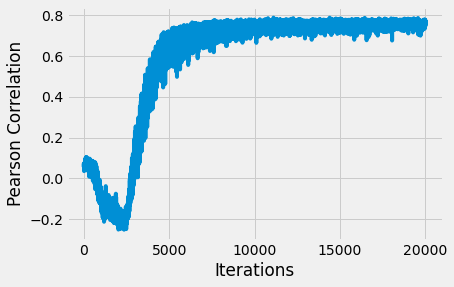

In [30]:
# robust scaler
plt.style.use('fivethirtyeight')
plt.xlabel('Iterations')
plt.ylabel('Pearson Correlation')
plt.plot(r_corr)
plt.show()


In [32]:
# Validation Loader
X_test = df_test.values 
y_test = y_test.values
X_test_tensor = torch.from_numpy(X_test)
y_test_tensor = torch.from_numpy(y_test)
test_tensor = torch.tensor(X_test_tensor, dtype=torch.float32)
ytest_tensor = torch.tensor(y_test_tensor, dtype=torch.float32)

# Passing to DataLoader
test_dataset = torch.utils.data.TensorDataset(test_tensor,ytest_tensor)
test_loader = torch.utils.data.DataLoader(test_dataset,batch_size=len(df_test), shuffle=False)

/tmp/ipykernel_6480/3488666605.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_tensor = torch.tensor(X_test_tensor, dtype=torch.float32)
/tmp/ipykernel_6480/3488666605.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ytest_tensor = torch.tensor(y_test_tensor, dtype=torch.float32)


In [33]:
ypred=[]
loss = 0
with torch.no_grad():
    model.eval()
    for  x in test_loader:
        x_test, target = x
        x_test = x_test.to(device)
        target = target.to(device)
        target = target.unsqueeze(1)
        y = model(x_test)
        ypred.append(y.cpu().detach().numpy().tolist())

In [34]:
pred = [item for sublist in ypred for item in sublist]
pred = [item for sublist in pred for item in sublist]
len(pred)

621

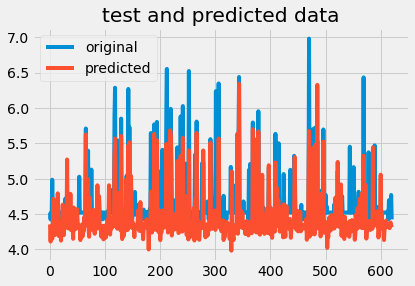

In [37]:
x_ax = range(len(df_test.values))
plt.plot(x_ax, y_test, label="original")
plt.plot(x_ax, pred, label="predicted")
plt.title("test and predicted data")
plt.legend()
plt.show()

Comparing metrics for regression. Pearson is good when the sample size is large enough to calculate the standard deviation. It also requires the samples to have a Gaussian or Gaussian-like distribution:
https://safjan.com/kaggle-evaluation-metrics-used-for-regression-problems/

In [39]:
mse = metrics.mean_squared_error(y_test, pred)
mae = metrics.mean_absolute_error(y_test, pred)
r2 = metrics.r2_score(y_test, pred)
r = np.corrcoef(y_test, pred)[1,0]
print("MSE: %.2f" % mse)
print("mean absolute error: %.2f" %mae)
print("pearson correlation: %.2f" %r)

MSE: 0.10
mean absolute error: 0.25
pearson correlation: 0.76
